In [130]:
# execute this for the 1st time
# !pip install -r example-requirements.txt 

# download file 
# !wget http://helon.usuarios.rdc.puc-rio.br/data/data3SS2009.mat # linux

# and place in folder data/

In [131]:
import scipy.io as sio
import numpy as np
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

Opening data file

In [132]:
fname = join(getcwd(),'data','data3SS2009.mat')
mat_contents = sio.loadmat(fname)

print (type(mat_contents))
mat_contents.keys()

<class 'dict'>


dict_keys(['__header__', '__version__', '__globals__', 'dataset', 'labels'])

Separating parameters and labels

In [133]:
print ('dataset: ',mat_contents['dataset'].shape)
print ('labels: ',mat_contents['labels'].shape)

dataset = mat_contents['dataset']
N, Chno, Nc = dataset.shape
# N: number of samples
# Chno: number of channels
# Nc: number of cases, experiments

y = mat_contents['labels'].reshape(Nc)
print ('y: ',len(y))
y[::50]

dataset:  (8192, 5, 850)
labels:  (1, 850)
y:  850


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17],
      dtype=uint8)

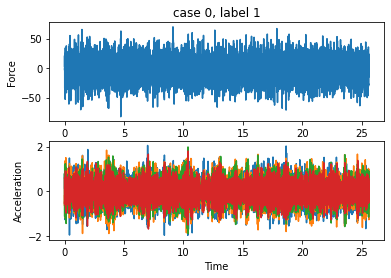

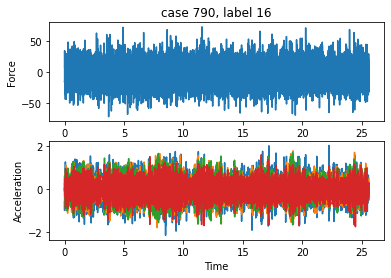

In [134]:
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar

Ts = 3.125 * 1e-3 # sampling time
time = (np.linspace(1,N,N) - 1) * Ts

for case in np.array([0,790]):
    plt.subplots()
    plt.subplot(211)
    plt.title('case %d, label %d' % (case, y[case]))
    plt.plot(time,Ch1[:,case])
    plt.ylabel('Force')
    plt.subplot(212)
    plt.plot(time,Ch2[:,case],time,Ch3[:,case],time,Ch4[:,case],time,Ch5[:,case])
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.show()

Transposing the channel dat: Ch(i) > X(i), i in {2,3,4,5}

In [135]:
x2 = Ch2.transpose()
x3 = Ch3.transpose()
x4 = Ch4.transpose()
x5 = Ch5.transpose()

Fitting AR model and building X1 matrix

In [136]:
modelOrder = 30

x2r = []
x3r = []
x4r = []
x5r = []

for case in x2: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1).fit()
    x2r.append(res.params)
for case in x3: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1).fit()
    x3r.append(res.params)
for case in x4: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1).fit()
    x4r.append(res.params)
for case in x5: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1).fit()
    x5r.append(res.params)

X1 = np.concatenate([x2r, x3r, x4r, x5r], axis=1)
X1.shape

(850, 120)

PCA analysis

Text(0, 0.5, 'Cumulative Explained Variance [%]')

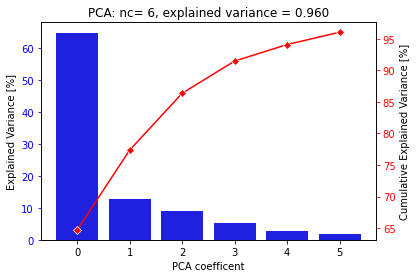

In [137]:
nComponents = 0.95  # variance ratio to be explained or number of components if integer

pca = PCA(n_components=nComponents).fit(X1)
pcaVariances = pca.explained_variance_ratio_
pcaComponents = [i for i in range(len(pcaVariances))]

ax = sns.barplot(pcaComponents, pcaVariances*100, color='b')
ax2 = ax.twinx()
ax2 = sns.lineplot(pcaComponents, np.cumsum(pcaVariances)*100, color='r', marker='D')
ax.tick_params(axis='y', colors='b')
ax2.tick_params(axis='y', colors='r')

ax.set_title('PCA: nc= ' + str(pcaVariances.shape[0]) + ', explained variance = ' + str(sum(pcaVariances))[:5])
ax.set_xlabel('PCA coefficent')
ax.set_ylabel('Explained Variance [%]')
ax2.set_ylabel('Cumulative Explained Variance [%]')

Building x2 by transforming the x1 data with the previous PCA model
Creating a pandas dataframe associated with x2

In [138]:
X2 = pca.fit_transform(X1)

Scaling features form both X1 and X2

In [139]:
X1_scaled = MinMaxScaler(feature_range=(-1,1)).fit_transform(X1)
X2_scaled = MinMaxScaler(feature_range=(-1,1)).fit_transform(X2)

print ("not scaled: ", X2[0], "\nscaled: ", X2_scaled[0])

not scaled:  [ 7.66136505 -1.41780663  0.80665171  0.89625556 -1.19463583 -0.13840328] 
scaled:  [ 0.75017416 -0.61278049  0.16699462 -0.2637636  -0.44727164 -0.14540835]


Creating pandas dataframe versions of the scaled x1, x1+label, x2 and x2+label

In [140]:
dfx1 = pd.DataFrame(X1_scaled)
dfx1_label = dfx1.copy()
dfx1_label['label'] = y

dfx2 = pd.DataFrame(X2_scaled)
dfx2_label = dfx2.copy()
dfx2_label['label'] = y

dfx2_label.sample(10)

,0,1,2,3,4,5,label
373,-0.147127,0.453203,-0.301158,-0.593392,-0.022657,-0.310824,8
285,0.487750,-0.650361,-0.359202,-0.031651,-0.634991,0.398032,6
222,-0.183017,0.986956,0.127455,-0.239550,0.238560,0.809408,5
130,0.901890,-0.512758,0.544066,-0.237106,0.556139,-0.057861,3
832,-0.929806,-0.481676,0.439523,-0.448091,-0.012735,0.211564,17
755,-0.458395,-0.431972,-0.717321,-0.561579,0.086353,-0.175098,16
295,0.379147,-0.536597,-0.284823,-0.020116,-0.648417,0.351684,6
71,0.464645,-0.523830,0.042103,-0.536403,0.374082,-0.377787,2
149,0.719281,-0.524306,0.327283,-0.529212,0.705961,-0.076430,3
209,-0.165043,0.910180,0.063799,-0.529790,0.089500,0.882016,5


AR x PCA heatmap

Text(609.9818181818181, 0.5, 'experiment')

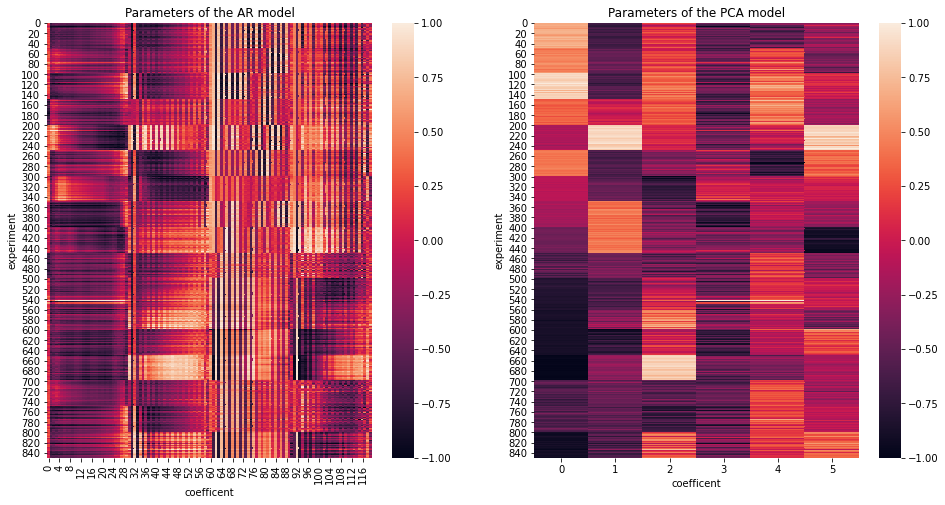

In [141]:
plt.subplots(figsize=(16,8))
plt.subplot(121)
ax = sns.heatmap(dfx1)
ax.set_title('Parameters of the AR model')
ax.set_xlabel('coefficent')
ax.set_ylabel('experiment')
plt.subplot(122)
ax2 = sns.heatmap(dfx2)
ax2.set_title('Parameters of the PCA model')
ax2.set_xlabel('coefficent')
ax2.set_ylabel('experiment')


Crossplot of the first three features of the PCA analysis

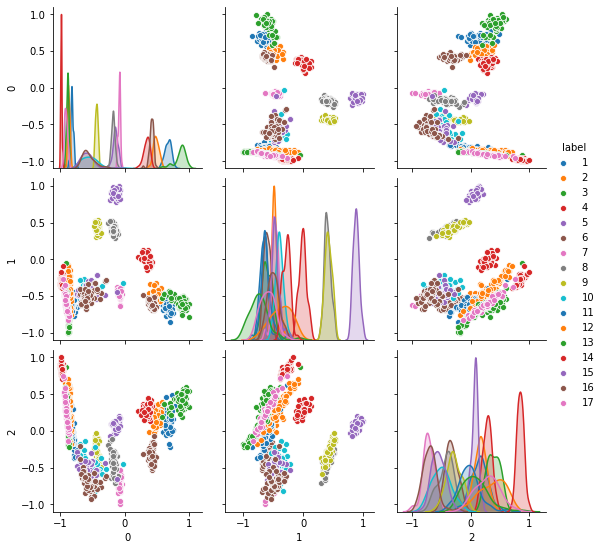

In [142]:

sns.pairplot(data=dfx2_label.iloc[:,[0,1,2,-1]], hue='label', palette='tab10')

Plotting Multidimenssional Spaces